In [1]:
import pandas as pd
import sklearn # make sure this is installed in your environment.
from sklearn.datasets import *
from sklearn import tree
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import math
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from typing import Tuple
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv(r'Mid07new_with_dist1_dist10_small.txt',sep=',')
df = df.drop(df.columns[0], axis=1)
df = df.drop(df.columns[12:29], axis=1)

In [33]:
#dummies
df = pd.read_csv(r'Mid07new_with_dist1_dist10_small.txt',sep=',')
df = df[['realprice1', 'realprice2', 'realprice3', 'realprice4',
       'br1', 'br2', 'br3', 'br4', 'residual.price.1', 'residual.price.2',
       'residual.price.3', 'residual.price.4','TRADEMANUFACTURER',
       'TRADENAME', 'TRADEMODEL', 'TRADEORIGIN', 'TRADEBODYTP',
       'TRADECYLINDER','brand']].copy()
df = pd.get_dummies(df,drop_first=True)

In [34]:
#LA dataset
df_LA = pd.read_csv(r'LA07 (2019 0612) with DIST1.txt',sep=' ')
df_LA = df_LA[['realprice1', 'realprice2', 'realprice3', 'realprice4',
       'br1', 'br2', 'br3', 'br4', 'X1', 'X2',
       'X3', 'X4','TRADEMANUFACTURER',
       'TRADENAME', 'TRADEMODEL', 'TRADEORIGIN', 'TRADEBODYTP',
       'TRADECYLINDER','brand']].copy()
df_LA=df_LA.rename(columns = {'X1':'residual.price.1','X2':'residual.price.2','X3':'residual.price.3','X4':'residual.price.4'})

df_LA = pd.get_dummies(df_LA,drop_first=True)

In [37]:
col_list = (df_LA.append([df])).columns.tolist()
df = df.reindex(columns=col_list, fill_value=0)
df_LA = df_LA.reindex(columns=col_list, fill_value=0)

In [38]:
df_LA

,realprice1,realprice2,realprice3,realprice4,br1,br2,br3,br4,residual.price.1,residual.price.2,...,TRADEBODYTP_Sport Utility,TRADEBODYTP_Sport Utility Pickup,TRADEBODYTP_Van,TRADEBODYTP_Wagon,TRADECYLINDER_3 Cyl,TRADECYLINDER_4 Cyl,TRADECYLINDER_5 Cyl,TRADECYLINDER_6 Cyl,TRADECYLINDER_8 Cyl,TRADECYLINDER_Rotary
1,9.932561,10.046773,9.884660,10.130922,0,0,1,0,-0.178768,1.415044,...,0,0,0,0,0,1,0,0,0,0
2,9.932561,10.046773,9.884660,10.130922,0,0,0,0,-0.178768,1.415044,...,1,0,0,0,0,0,0,1,0,0
3,9.932561,10.046773,9.884660,10.130922,1,0,0,0,-0.178768,1.415044,...,0,0,0,0,0,1,0,0,0,0
4,9.932561,10.046773,9.884660,10.130922,0,0,1,0,-0.178768,1.415044,...,0,0,0,0,0,1,0,0,0,0
5,9.932561,10.046773,9.884660,10.130922,0,0,1,0,-0.178768,1.415044,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2480,9.916262,9.906234,9.930665,10.027148,0,1,0,0,-0.359503,0.827536,...,0,0,0,0,0,1,0,0,0,0
2481,9.916262,9.906234,9.930665,10.027148,1,0,0,0,-0.359503,0.827536,...,0,0,0,0,0,0,0,1,0,0
2482,9.916262,9.906234,9.930665,10.027148,0,0,0,0,-0.359503,0.827536,...,1,0,0,0,0,0,0,1,0,0
2483,9.916262,9.906234,9.930665,10.027148,0,1,0,0,-0.359503,0.827536,...,0,0,0,0,0,1,0,0,0,0


## Data Spliting 

In [40]:
X_train = df.drop(['brand'], axis=1)
y_train = df.brand
X_test = df_LA.drop(['brand'], axis=1)
y_test = df_LA.brand

In [41]:
#feature extraction 
def feature_extraction(X_train,X_test):
    sel_ = SelectFromModel(LogisticRegression(penalty='l2',solver='liblinear'),threshold="1.5*mean")
    sel_.fit(X_train, y_train)
    selected_feat = X_train.columns[(sel_.get_support())]
    X_train = pd.DataFrame(sel_.transform(X_train), columns =selected_feat)
    X_test = pd.DataFrame(sel_.transform(X_test), columns =selected_feat)
    return X_train,X_test
X_train,X_test = feature_extraction(X_train,X_test)

In [42]:
X_train

,realprice1,realprice2,realprice4,br1,br2,br3,br4,residual.price.1,residual.price.4,TRADEMANUFACTURER_Honda,...,TRADEMODEL_TT,TRADEMODEL_Tacoma,TRADEMODEL_Tahoe,TRADEMODEL_Taurus,TRADEMODEL_Tercel,TRADEMODEL_Tundra,TRADEMODEL_Versa,TRADEMODEL_Windstar,TRADEMODEL_Xterra,TRADEBODYTP_Hatchback
0,9.932561,10.046773,10.130922,0.0,0.0,1.0,0.0,-0.178768,0.954131,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.932561,10.046773,10.130922,0.0,0.0,0.0,0.0,-0.178768,0.954131,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.932561,10.046773,10.130922,1.0,0.0,0.0,0.0,-0.178768,0.954131,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.932561,10.046773,10.130922,0.0,0.0,1.0,0.0,-0.178768,0.954131,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.932561,10.046773,10.130922,0.0,0.0,1.0,0.0,-0.178768,0.954131,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,9.908475,9.996522,10.130922,1.0,0.0,0.0,0.0,-0.647496,0.954131,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
817,9.908475,9.996522,10.130922,0.0,0.0,1.0,0.0,-0.647496,0.954131,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
818,9.908475,9.996522,10.130922,0.0,0.0,1.0,0.0,-0.647496,0.954131,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
819,9.908475,9.996522,10.130922,1.0,0.0,0.0,0.0,-0.647496,0.954131,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Cluster before training

In [8]:
def get_clusters(X_train: pd.DataFrame, X_test: pd.DataFrame, n_clusters: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    applies k-means clustering to training data to find clusters and predicts them for the test set
    """
    clustering = KMeans(n_clusters=n_clusters, random_state=42,n_jobs=-1)
    clustering.fit(X_train)
    # apply the labels
    train_labels = clustering.labels_
    X_train_clstrs = X_train.copy()
    X_train_clstrs['clusters'] = train_labels
    
    # predict labels on the test set
    test_labels = clustering.predict(X_test)
    X_test_clstrs = X_test.copy()
    X_test_clstrs['clusters'] = test_labels
    return X_train_clstrs, X_test_clstrs
X_train, X_test = get_clusters(X_train, X_test, 6)

C:\Users\luoyu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


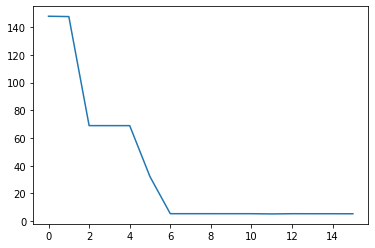

In [974]:
def calculate_WSS(points, kmax):
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            sse1 = (points.iloc[i, 0] - curr_center[0]) ** 2 
            sse2 = (points.iloc[i, 1] - curr_center[1]) ** 2
            curr_sse += sse1+sse2
      
        sse.append(curr_sse)
    return sse
result = calculate_WSS(X_train, 16)
plt.plot(result)

## Traning Biclass

In [9]:
def train_models(X_train,y_train,model):
    if model == 'decision_tree':
        clf = tree.DecisionTreeClassifier()
    if model == 'linear_SGD_classifier':
        clf = SGDClassifier(loss="log")
    if model == 'naive_bayes':
        clf = BernoulliNB()
    if model == 'AdaBoost':
        clf = AdaBoostClassifier(n_estimators=100)
    if model == 'random_forest':
        clf = RandomForestClassifier(n_estimators= 400,min_samples_split=10,min_samples_leaf=4,max_features='sqrt',max_depth= 90,bootstrap= True)
    if model == 'gradient_boost':
        clf = GradientBoostingClassifier(subsample=0.9,n_estimators=400,min_samples_split=0.5,min_samples_leaf=0.1,max_features= 'sqrt',max_depth= 3,loss= 'deviance',learning_rate= 0.075,criterion= 'mae')
    if model == 'xgboost':
        clf = XGBClassifier()
    if model == 'LogisticRegressionCV':
        clf = LogisticRegressionCV(cv=5, random_state=0,solver = 'liblinear',max_iter=1000)
    if model == 'RandomizedSearchCV':    
        rf = RandomForestClassifier()
        clf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    clf = clf.fit(X_train, y_train)
    return clf

In [10]:
def cv_estimate(n_splits=None):
    cv = KFold(n_splits=n_splits)
    cv_clf = ensemble.GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv.split(X_train, y_train):
        cv_clf.fit(X_train[train], y_train[train])
        val_scores += heldout_score(cv_clf, X_train[test], y_train[test])
    val_scores /= n_splits
    return val_scores

In [18]:
classifiers = ['gradient_boost','random_forest','LogisticRegressionCV']

In [12]:
def binary_classifier(X_train,y_train,brand,model):  
    y_train = [1 if i==brand else 0 for i in y_train]
    clf = train_models(X_train,y_train,model=model)
    return clf
def classifier(X_train,y_train,X_test,model,acc_or_MAD):
    p_list = [] # 4*pred
    fin_pred = [] 
    fin_pred_list = []
    for i in range(4):
        clf = binary_classifier(X_train,y_train,i+1,model)
        pred_prob = clf.predict_proba(X_test)
        pred = [i[1] for i in pred_prob]  #probablity prediction of class i+1
        p_list.append(pred)
    for i in range(len(pred)):
        values = [item[i] for item in p_list] 
        pred_label = values.index(max(values))+1
        pred_label_list = [0]*4
        pred_label_list[pred_label-1]=1
        fin_pred.append(pred_label)
        fin_pred_list.append(pred_label_list)
    if acc_or_MAD == 0: return fin_pred_list        #for MAD
    if acc_or_MAD == 1: return fin_pred            #for accuracy

In [13]:
def norm_classifier(X_train,y_train,X_test,model):
    p_list = []
    norm_pred = []
    for i in range(4):
        clf = binary_classifier(X_train,y_train,i+1,model)
        pred_prob = clf.predict_proba(X_test)
        pred = [i[1] for i in pred_prob]
        p_list.append(pred)
    for i in range(len(pred)):
        values = [item[i] for item in p_list] 
        #print(values)
        norm_pred.append([float(i)/sum(values) for i in values])
    return norm_pred
def MAD(norm_pred,y_test):
    MAD_list=[]
    for i in range(len(y_test)):
        mad_row = [1-n if j==y_test[i]-1 else n for j, n in enumerate(norm_pred[i]) ]
        MAD_list.append(sum(mad_row))
    return sum(MAD_list)/len(MAD_list)

In [28]:
for i in classifiers:
    print(i)
#normMAD
    norm_pred = norm_classifier(X_train,y_train,X_test, i)
    print('normMAD: ', round(MAD(norm_pred,list(y_test)),2))
#0or1MAD 
    fin_pred = classifier(X_train,y_train,X_test, i, 0)
    print('0or1MAD: ', round(MAD(fin_pred,list(y_test)),2))
#accuracy
    fin_pred = classifier(X_train,y_train,X_test, i, 1)
    print('accuracy: ', round(accuracy_score(y_test, fin_pred),2))
    print('')

gradient_boost
normMAD:  0.96
0or1MAD:  0.72
accuracy:  0.64

random_forest
normMAD:  1.04
0or1MAD:  0.71
accuracy:  0.65

LogisticRegressionCV
normMAD:  1.11
0or1MAD:  0.73
accuracy:  0.64



In [29]:
##accuracy
ave_list_acc,ave_list_mad,ave_list_norm = [],[],[]
for i in range(10):
    fin_pred = classifier(X_train,y_train,X_test, 'linear_SGD_classifier',1)
    ave_list_acc.append(accuracy_score(y_test, fin_pred))
    fin_pred = classifier(X_train,y_train,X_test, 'linear_SGD_classifier',0)
    ave_list_mad.append(MAD(fin_pred,list(y_test)))    
    norm_pred = norm_classifier(X_train,y_train,X_test, 'linear_SGD_classifier')
    ave_list_norm.append(MAD(norm_pred,list(y_test)))    
print('linear_SGD_classifier')
print('0or1MAD: ',round(sum(ave_list_mad)/10,2))
print('normMAD', round(sum(ave_list_norm)/10,2))
print('accuracy:',round(sum(ave_list_acc)/10,2))

linear_SGD_classifier
0or1MAD:  0.88
normMAD 0.87
accuracy: 0.55


In [984]:
fin_pred = classifier(X_train,y_train,X_test, 'gradient_boost', 1)
wrong_list,wrong_predict = [],[]
for i in range(len(fin_pred)):
    if fin_pred[i]!=y_test[i]:
        wrong_list.append(y_test[i])
        wrong_predict.append(fin_pred[i])

KeyError: 0

## Training multiclass

In [1094]:
classifiers = ['LogisticRegressionCV']

In [1105]:
def train_models_multi(X_train,y_train,model):
    if model == 'decision_tree':
        clf = tree.DecisionTreeClassifier()
    if model == 'linear_SGD_classifier':
        clf = SGDClassifier(loss="log")
    if model == 'naive_bayes':
        clf = BernoulliNB()
    if model == 'AdaBoost':
        clf = AdaBoostClassifier(n_estimators=100)
    if model == 'random_forest':
        clf = RandomForestClassifier(n_estimators= 400,min_samples_split=10,min_samples_leaf=4,max_features='sqrt',max_depth= 90,bootstrap= True)
    if model == 'gradient_boost':
        clf = GradientBoostingClassifier(subsample=0.9,n_estimators=800,min_samples_split=0.5,min_samples_leaf=0.1,max_features= 'sqrt',max_depth= 3,loss= 'deviance',learning_rate= 0.075,criterion= 'mae')
    if model == 'xgboost':
        clf = XGBClassifier()
    if model == 'LogisticRegressionCV':
        clf = LogisticRegressionCV(cv=5, random_state=0,max_iter=4000)
    if model == 'RandomizedSearchCV':    
        rf = RandomForestClassifier()
        clf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    clf = clf.fit(X_train, y_train)
    return clf

In [1055]:
def multi_classifier(X_train,y_train,X_test,model,acc_or_MAD):
    p_list = []
    fin_pred = []
    fin_pred_list = []
    clf = train_models_multi(X_train,y_train,model=model)
    pred_prob = clf.predict_proba(X_test)  
    
    for values in pred_prob:
        pred_label = list(values).index(max(values))+1
        pred_label_list = [0]*4
        pred_label_list[pred_label-1]=1
        fin_pred.append(pred_label)
        fin_pred_list.append(pred_label_list)
    if acc_or_MAD == 0: return fin_pred_list        #for MAD
    if acc_or_MAD == 1: return fin_pred  
    return pred_prob
def multi_norm_classifier(X_train,y_train,X_test,model):
    p_list = []
    norm_pred = []
    clf = train_models_multi(X_train,y_train,model=model)
    pred_prob = clf.predict_proba(X_test)
    for values in pred_prob:
        norm_pred.append([float(i)/sum(values) for i in values])
    return norm_pred

In [1106]:
for i in classifiers:
    print(i)
#normMAD
    norm_pred = multi_norm_classifier(X_train,y_train,X_test, i)
    print('normMAD: ', round(MAD(norm_pred,list(y_test)),2))
#0or1MAD 
    fin_pred = multi_classifier(X_train,y_train,X_test, i, 0)
    print('0or1MAD: ', round(MAD(fin_pred,list(y_test)),2))
#accuracy
    fin_pred = multi_classifier(X_train,y_train,X_test, i, 1)
    print('accuracy: ', round(accuracy_score(y_test, fin_pred),2))
    print('')

LogisticRegressionCV
normMAD:  0.91
0or1MAD:  0.65
accuracy:  0.67



## Gridsearch

In [716]:
#gridsearch parameters
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

parameters = {
    "loss":["deviance","exponential"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators" : [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    }

In [762]:
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
lrcv = LogisticRegressionCV()
clf = RandomizedSearchCV(estimator = gb, param_distributions = parameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
clf = clf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


In [763]:
clf.best_params_

{'subsample': 0.9,
 'n_estimators': 800,
 'min_samples_split': 0.46363636363636374,
 'min_samples_leaf': 0.1,
 'max_features': 'sqrt',
 'max_depth': 3,
 'loss': 'deviance',
 'learning_rate': 0.075,
 'criterion': 'mae'}